In [2]:
import numpy as np
import pandas as pd

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

### to do
1. Make table with gen statistics ?

In [3]:
## drop unnecessary stuff
raw_df = pd.read_csv('erg1_f21.csv')
df = raw_df.drop(['Questions, comments? other?', 'Did you send a pic of your time trial splits to one of the coaches?'], axis=1)
df = df.drop_duplicates()
df = df.rename(columns={"500m Time (M:SS:X)":"overall_time", "Time (MM:SS:X) (PLEASE USE ONLYS COLONS (:) not DECIMALS!!). 2:30:0 NOT 2:30.0!!!":"overall_time", "Split 1 (MM:SS:X)": "split_1", "Split 2 (MM:SS:X)": "split_2", "Split 3 (MM:SS:X)":"split_3", "Split 4 (MM:SS:X)":"split_4", "Split 5 (MM:SS:X)":"split_5"})
df = df.drop(['Split 1 (M:SS.X)', 'Split 2 (M:SS.X)', 'Split 3 (M:SS.X)', 'Split 4 (M:SS.X)', 'Split 5 (M:SS.X)', 'Gender.1'], axis=1)

In [4]:
# get secret names
codenames = pd.read_csv('f21_codenames.csv')
names_dct = dict(zip(codenames['Name'], codenames['Codename']))
names = np.array(df['Name'])

# rename and place into df
for i in np.arange(len(names)):
    names[i] = names_dct[names[i]]
df['Name'] = names
df.head()

,Timestamp,Name,Gender,Pic received?,overall_time,Side,Weight (lb),split_1,split_2,split_3,split_4,split_5
0,01/10/2021 20:34:10,elephant seal,m,Rosa,3:00:0,Left,154,02:49:05.000,2:46:5,2:55:0,3:10:0,3:19:0
1,03/10/2021 22:37:26,flying lizard,m,NaN,2:38:5,Right,170,2:27:5,2:24:0,2:40:0,2:50:0,2:51:1
2,04/10/2021 21:31:45,lion,m,NaN,2:16:9,Right,144,2:09:0,2:05:0,2:11:0,2:22:0,2:37:5
3,06/10/2021 11:35:20,Anna's hummingbird,f,Angie,2:56:5,Right,113,02:51:05,02:53:00,02:56:00,02:57:05,03:04:05
4,06/10/2021 12:04:28,snowshoe hare,f,Angie,2:37:5,Right,122,2:32:0,2:31:0,2:36:0,2:42:0,2:45:0


In [5]:
# roster comparison
roster = pd.read_csv('roster_f21.csv')
paddlers = np.array(roster['Name'])

In [6]:
## finds ppl who didnt submit
submitted = np.array(df['Name'])
no_submission = list(set(paddlers) - set(submitted))

In [7]:
## finds ppl who didnt submit a pic
no_pic = df[df['Pic received?'].isna()]

In [8]:
# convert splits
for i in np.arange(0,6):
    col_name = 'split_%s' % i
    if i == 0:
        col_name = 'overall_time'
    time_col = np.array(df[col_name])
    new_time = []
    for j in np.arange(len(time_col)):
        split_str = time_col[j]
        arr = np.array(split_str.split(':')).astype(np.double)
        seconds = arr.item(0)*60 + arr.item(1)
        if len(arr) == 3:
            seconds += arr.item(2)*0.1
        new_time = np.append(seconds, new_time)
    df = df.drop([col_name], axis=1)
    df[col_name+'_seconds'] = new_time

In [9]:
sd_times = []

for index, row in df.iterrows():
    name = row['Name']
    indiv_splits = []
    indiv_std = 0
    
    for i in np.arange(1, 5):
        split_num = 'split_%s_seconds' % i
        indiv_splits = np.append(indiv_splits, row[split_num])
    
    indiv_std = np.std(indiv_splits, dtype=np.float64)
    #indiv_times[name] = indiv_std
    sd_times = np.append(sd_times, indiv_std)

df['SD (seconds)'] = sd_times

In [10]:
## mens vs womens
womens = df.loc[df['Gender'] == 'f']
mens = df.loc[df['Gender'] == 'm']

print('Avg womens split SD: %s' % np.mean(womens['SD (seconds)']))
print('Avg mens split SD: %s' % np.mean(mens['SD (seconds)']))

all_mean_SD = np.mean(df['SD (seconds)'])
print('Avg overall split SD: %s' % all_mean_SD)

Avg womens split SD: 12.199242027587704
Avg mens split SD: 8.956003933392509
Avg overall split SD: 10.469515044016932


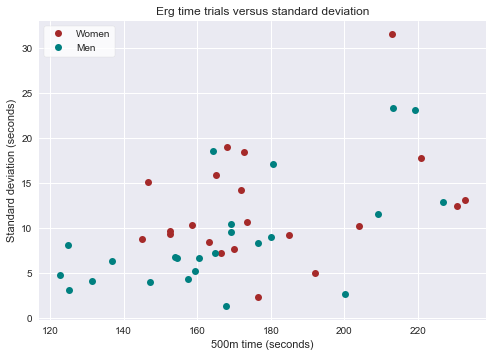

In [11]:
groups = df.groupby("Gender")
gr = {'m':'Men', 'f':'Women'}
colors = {'m':'teal', 'f':'brown'}

for name, group in groups:
    plt.plot(group['overall_time_seconds'], group["SD (seconds)"],
             color=colors[name], marker="o", linestyle="", label=gr[name])

plt.xlabel('500m time (seconds)')
plt.ylabel('Standard deviation (seconds)')
plt.title('Erg time trials versus standard deviation')
plt.legend(loc='upper left', frameon=True, facecolor='white')
plt.show()

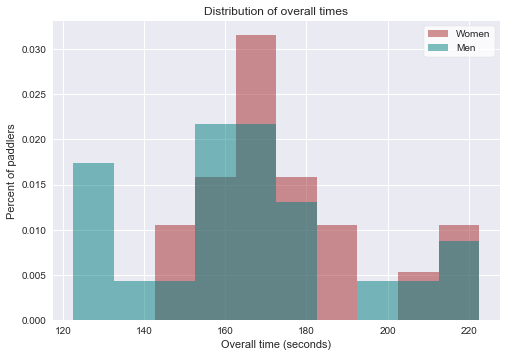

In [25]:
mens_overall = np.array(mens['overall_time_seconds'])
low_x = min(mens_overall)
high_x = max(mens_overall)
time_bins = np.arange(low_x, high_x+1, 10)

for name, group in groups:
    plt.hist(x=group['overall_time_seconds'], bins=time_bins, density=True,
             color=colors[name], alpha=0.5, label=gr[name])

plt.xlabel('Overall time (seconds)')
plt.ylabel('Percent of paddlers')
plt.title('Distribution of overall times')
plt.legend(loc='upper right', frameon=True, facecolor='white')
plt.show()

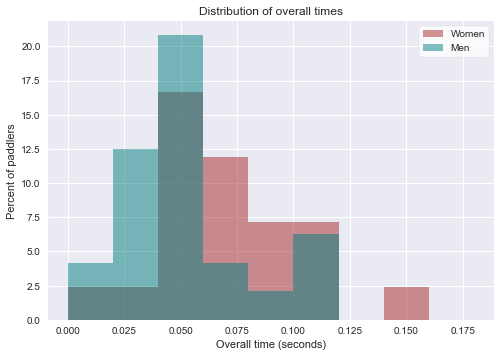

In [40]:
for name, group in groups:
    group['SD/overall'] = group['SD (seconds)']/group['overall_time_seconds']
    plt.hist(x=group['SD/overall'], bins=np.arange(0,0.2,0.02), density=True,
             color=colors[name], alpha=0.5, label=gr[name])

plt.xlabel('Overall time (seconds)')
plt.ylabel('Percent of paddlers')
plt.title('Distribution of overall times')
plt.legend(loc='upper right', frameon=True, facecolor='white')
plt.show()

In [15]:
## export csv
# df.to_csv('cleaned_erg1_f21.csv')